# Notebook 06: Synthesis

## Bringing It All Together

This notebook presents a summary dashboard drawing on the analyses from
Notebooks 01-05. Rather than introducing new data, it synthesizes the key
findings into a coherent narrative about US-Europe inequality differences.

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
import seaborn as sns

from data.config import FOCUS_COUNTRIES, COUNTRY_NAMES
from data.plotting import (set_style, country_color, country_name,
                           save_figure, annotate_countries)
from data import swiid, wid, health_social

set_style()

***
## 1. The Headline Numbers

A summary comparison table of key inequality metrics for the focus countries.

In [2]:
summary_countries = FOCUS_COUNTRIES
target_year = 2020

# Disposable income Gini
gini_disp = swiid.get_gini(summary_countries, gini_type='disp',
                            start_year=2017, end_year=2022)

# Market income Gini
gini_mkt = swiid.get_gini(summary_countries, gini_type='mkt',
                           start_year=2017, end_year=2022)

# Top 10% pre-tax income share
top10_pretax = wid.get_income_shares(
    summary_countries, income_concept='pretax',
    percentiles=['p90p100'], start_year=2017, end_year=2022)

# Top 10% wealth share
top10_wealth = wid.get_wealth_shares(
    summary_countries, percentiles=['p90p100'],
    start_year=2017, end_year=2022)

# Build summary table
rows = []
for cc in summary_countries:
    row = {'Country': country_name(cc)}

    # Disposable Gini
    if not gini_disp.empty:
        d = gini_disp[gini_disp['country_code'] == cc]
        if not d.empty:
            row['Gini (disp.)'] = f"{d.iloc[-1]['gini']:.2f}"

    # Market Gini
    if not gini_mkt.empty:
        m = gini_mkt[gini_mkt['country_code'] == cc]
        if not m.empty:
            row['Gini (mkt.)'] = f"{m.iloc[-1]['gini']:.2f}"

    # Redistribution
    if 'Gini (disp.)' in row and 'Gini (mkt.)' in row:
        mkt_val = float(row['Gini (mkt.)'])
        disp_val = float(row['Gini (disp.)'])
        if mkt_val > 0:
            row['Redistribution'] = f"{(mkt_val - disp_val)/mkt_val*100:.0f}%"

    # Top 10% income share
    if not top10_pretax.empty:
        t = top10_pretax[top10_pretax['country'] == cc]
        if not t.empty:
            row['Top 10% income'] = f"{t.iloc[-1]['value']*100:.1f}%"

    # Top 10% wealth share
    if not top10_wealth.empty:
        w = top10_wealth[top10_wealth['country'] == cc]
        if not w.empty:
            row['Top 10% wealth'] = f"{w.iloc[-1]['value']*100:.1f}%"

    rows.append(row)

summary_df = pd.DataFrame(rows)
if not summary_df.empty:
    display(summary_df.set_index('Country'))
else:
    print('Could not build summary table.')

,Gini (disp.),Gini (mkt.),Redistribution,Top 10% income,Top 10% wealth
Country,,,,,
United States,38.90,53.00,27%,46.9%,69.6%
United Kingdom,32.00,52.80,39%,35.8%,57.1%
France,29.80,51.20,42%,34.4%,59.6%
Germany,30.40,52.70,42%,37.5%,58.5%
Sweden,28.90,49.40,41%,29.3%,68.2%
Denmark,28.80,49.10,41%,32.8%,50.7%
Norway,26.10,47.40,45%,29.9%,53.0%


***
## 2. Summary Dashboard

A 2x2 grid of key visualizations from the analysis.

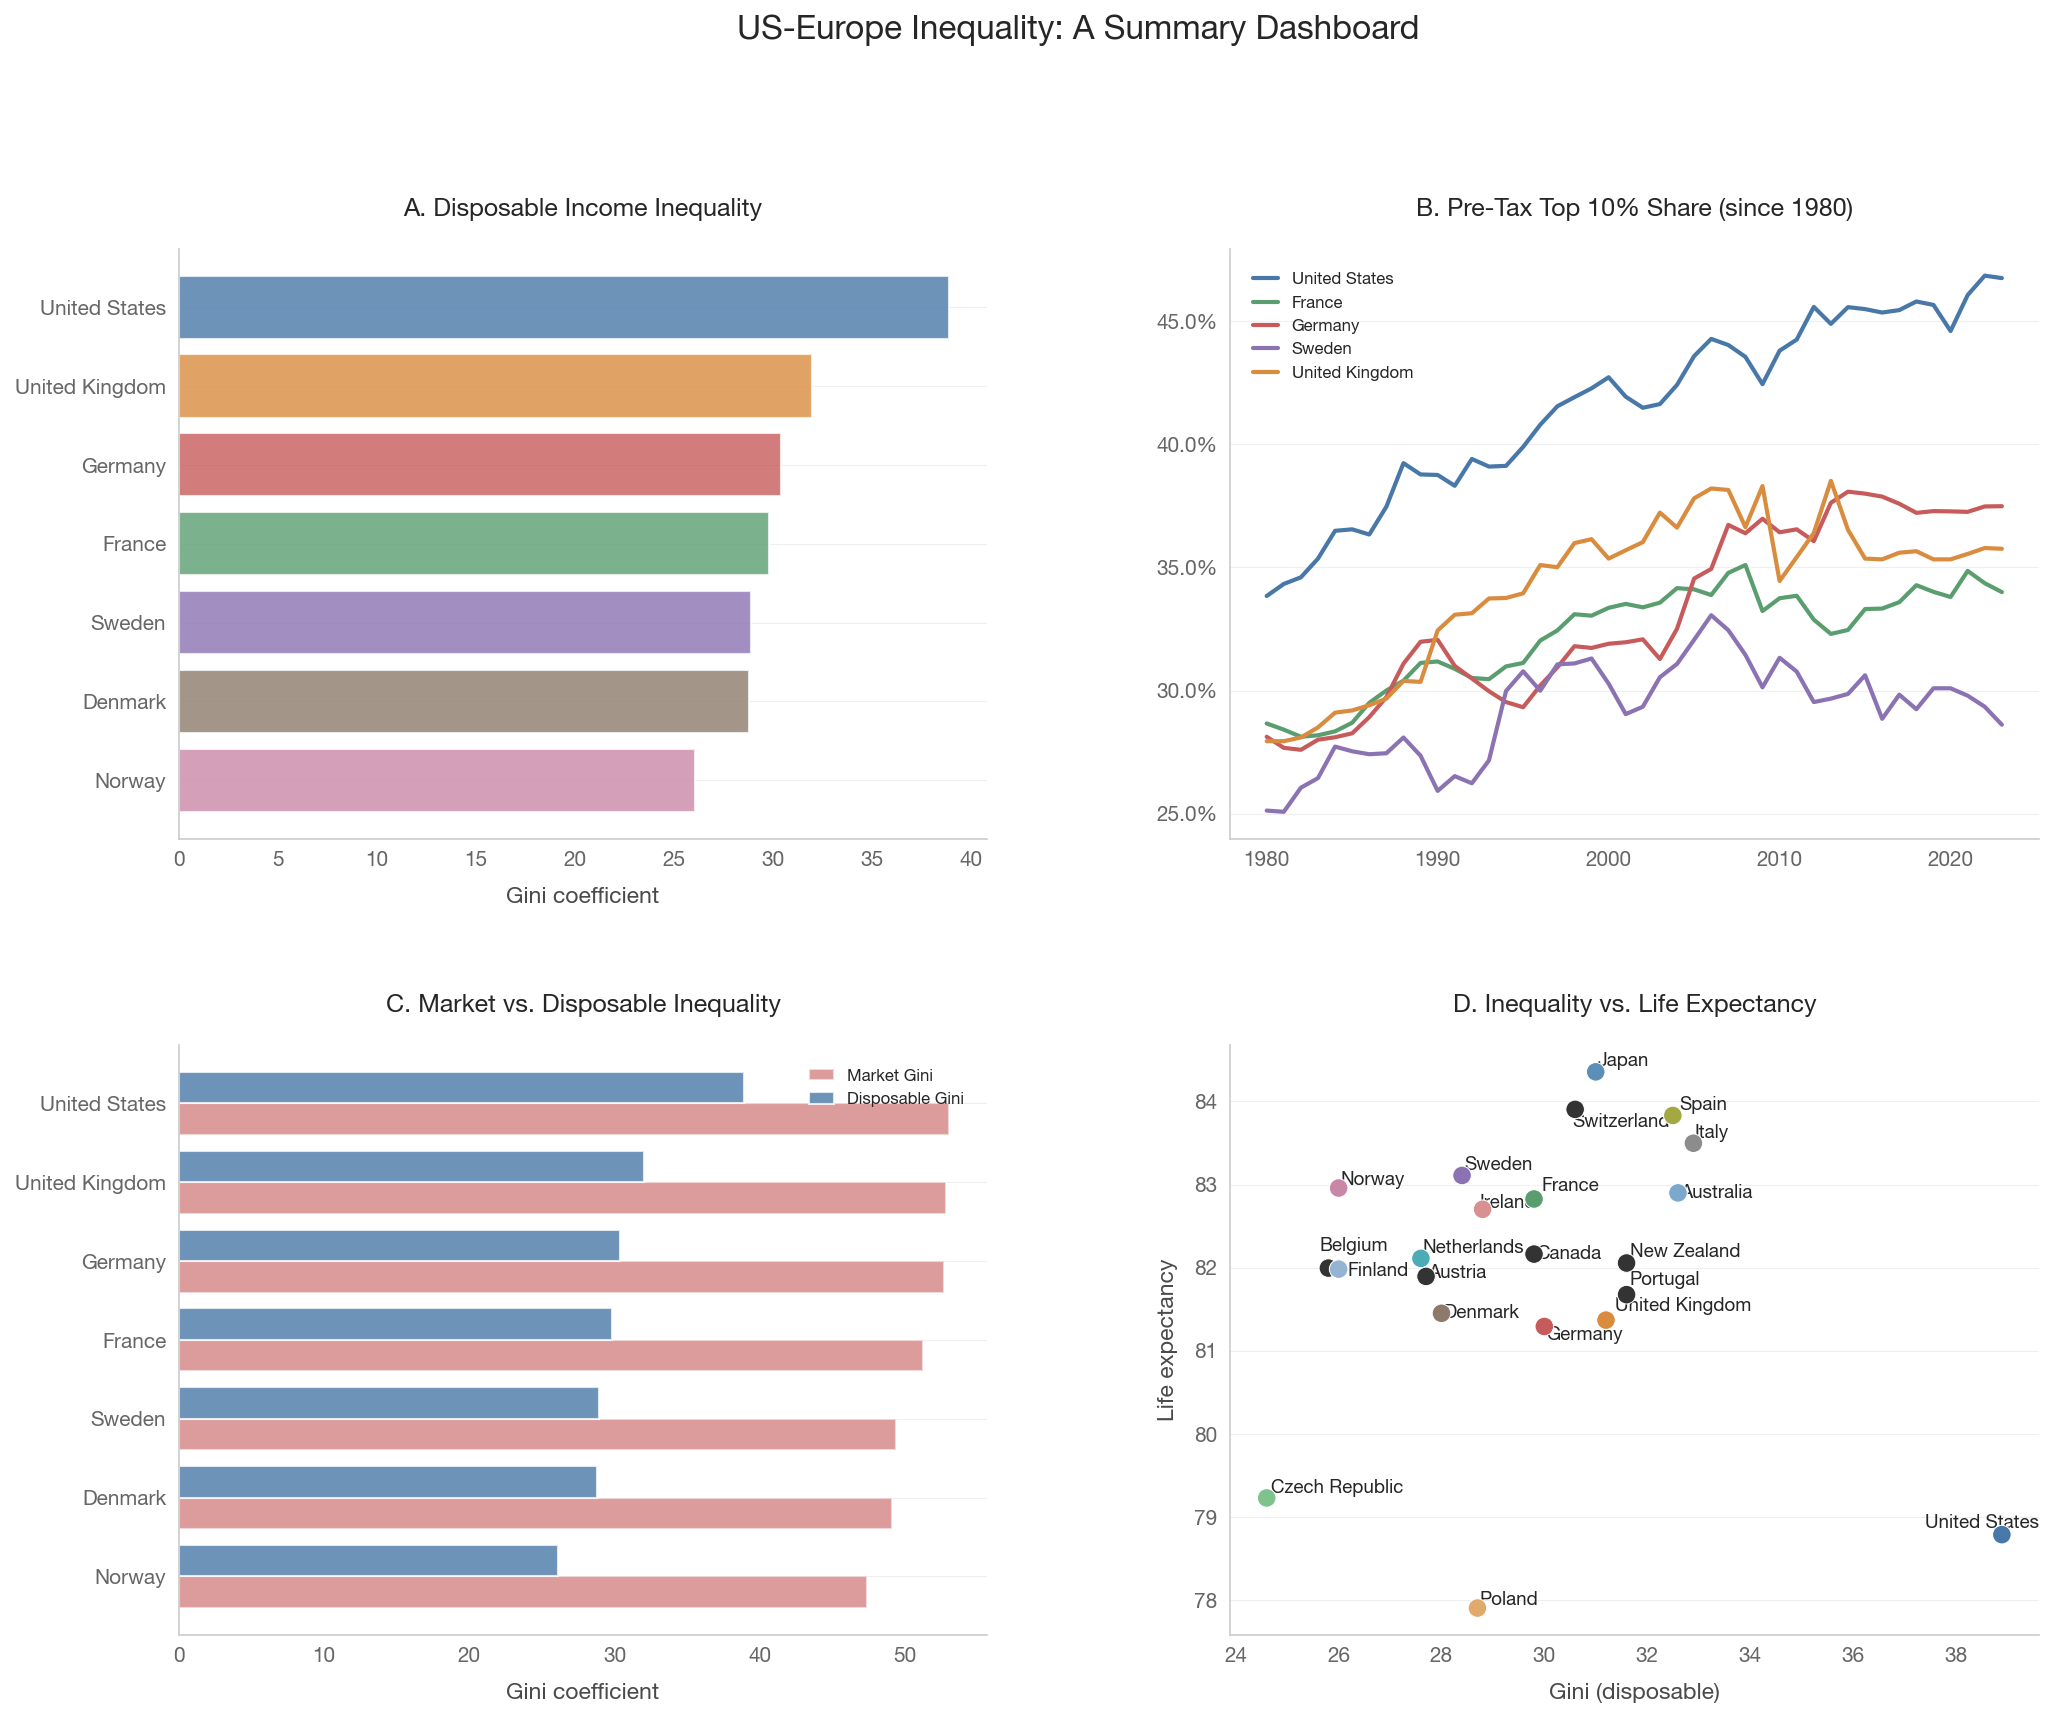

In [3]:
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2, hspace=0.35, wspace=0.3)

# Panel A: Disposable Gini bar chart
ax1 = fig.add_subplot(gs[0, 0])
if not gini_disp.empty:
    latest = (gini_disp.sort_values('year', ascending=False)
              .groupby('country_code').first().reset_index()
              .sort_values('gini'))
    colors = [country_color(c) for c in latest['country_code']]
    ax1.barh([country_name(c) for c in latest['country_code']],
             latest['gini'], color=colors, alpha=0.8)
    ax1.set_xlabel('Gini coefficient')
    ax1.set_title('A. Disposable Income Inequality', fontsize=12, fontweight='bold')

# Panel B: Pre-tax top 10% share time series
ax2 = fig.add_subplot(gs[0, 1])
ts_countries = ['US', 'FR', 'DE', 'SE', 'GB']
pretax_top10 = wid.get_top_shares_timeseries(
    ts_countries, percentile='p90p100', concept='pretax', start_year=1980)
if not pretax_top10.empty:
    for cc in ts_countries:
        data = pretax_top10[pretax_top10['country'] == cc].sort_values('year')
        if not data.empty:
            ax2.plot(data['year'], data['value'],
                     color=country_color(cc), linewidth=2,
                     label=country_name(cc))
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax2.legend(fontsize=8)
    ax2.set_title('B. Pre-Tax Top 10% Share (since 1980)', fontsize=12, fontweight='bold')

# Panel C: Redistribution — market vs disposable Gini
ax3 = fig.add_subplot(gs[1, 0])
redist = swiid.get_redistribution(summary_countries, start_year=2017, end_year=2022)
if not redist.empty:
    latest_r = (redist.sort_values('year', ascending=False)
                .groupby('country_code').first().reset_index())
    latest_r = latest_r.dropna(subset=['gini_mkt', 'gini_disp'])
    latest_r = latest_r[latest_r['country_code'] != ''].sort_values('gini_disp')

    y_pos = np.arange(len(latest_r))
    ax3.barh(y_pos, latest_r['gini_mkt'].values, 0.4,
             label='Market Gini', color='#c75b5b', alpha=0.6)
    ax3.barh(y_pos + 0.4, latest_r['gini_disp'].values, 0.4,
             label='Disposable Gini', color='#4878a8', alpha=0.8)
    ax3.set_yticks(y_pos + 0.2)
    ax3.set_yticklabels([country_name(c) for c in latest_r['country_code']])
    ax3.set_xlabel('Gini coefficient')
    ax3.legend(fontsize=8)
    ax3.set_title('C. Market vs. Disposable Inequality', fontsize=12, fontweight='bold')

# Panel D: Gini vs life expectancy
ax4 = fig.add_subplot(gs[1, 1])
spirit_data = health_social.get_spirit_level_data(year=2019)
if (not spirit_data.empty and 'gini_disp' in spirit_data.columns
        and 'life_expectancy' in spirit_data.columns):
    df = spirit_data.dropna(subset=['gini_disp', 'life_expectancy'])
    colors = [country_color(c) if c in COUNTRY_NAMES else '#999'
              for c in df['country_code']]
    ax4.scatter(df['gini_disp'], df['life_expectancy'],
                c=colors, s=80, zorder=5, edgecolors='white', linewidth=0.5)
    annotate_countries(ax4, df['gini_disp'].values,
                       df['life_expectancy'].values,
                       df['country_code'].values)
    ax4.set_xlabel('Gini (disposable)')
    ax4.set_ylabel('Life expectancy')
    ax4.set_title('D. Inequality vs. Life Expectancy', fontsize=12, fontweight='bold')

fig.suptitle('US-Europe Inequality: A Summary Dashboard', fontsize=16, fontweight='bold', y=1.01)
save_figure(fig, '06_synthesis_dashboard')
plt.show()


***
## 3. The Story in Five Charts

Each chart corresponds to one of the core questions from our analysis.

### Chart 1: Measurement matters

Different inequality measures can rank countries differently. The Gini
coefficient is sensitive to the middle of the distribution, while top
income shares capture concentration at the top. The US looks more unequal
by top shares than by Gini, because its inequality is concentrated at the
very top.

**Takeaway:** Always ask *which measure* when someone says "inequality is higher."

### Chart 2: Predistribution + redistribution

Europe achieves lower inequality through *both* more equal market incomes
(predistribution) and more aggressive tax-transfer systems (redistribution).
The US has higher pre-tax inequality *and* less redistribution — a double
disadvantage.

The Blanchet et al. (2022) finding that predistribution dominates depends on
counting social insurance as pre-tax income. The conceptual debate is about
where to draw the line between market and state.

**Takeaway:** The answer depends on how you define "the market" vs. "the state."

### Chart 3: Absolute vs. relative

The US has higher absolute income levels at the top (P90 and above), but
the gap narrows or reverses at the bottom (P10). US income growth since
1980 has been heavily skewed toward the top, while European growth has been
more evenly distributed.

PPP comparisons also miss the "social wage" — Europeans receive public
services (healthcare, childcare, education) that don't appear in disposable
income figures.

**Takeaway:** "Americans are richer" is true at the top but misleading at the bottom.

### Chart 4: The wealth paradox

Nordic countries have low income inequality but high wealth concentration.
This paradox arises because universal public services and pensions reduce
the need for private savings, paradoxically concentrating measured wealth
among the wealthy.

**Takeaway:** Income and wealth inequality are distinct phenomena with
different drivers.

### Chart 5: Inequality and societal health

More unequal rich countries tend to have worse health and social outcomes,
but the relationship is fragile — sensitive to country selection, time period,
and whether you control for GDP per capita. The US is an extreme outlier
that drives many of the correlations.

**Takeaway:** The Spirit Level thesis is suggestive but far from proven.

***
## 4. What We've Learned

### The three questions, revisited

**1. What does "more unequal" actually mean?**

It depends on the measure. The Gini coefficient, top income shares, the Palma
ratio, and percentile ratios each capture different aspects of the distribution.
They can rank countries differently, and the choice of measure is itself a
normative decision about which part of the distribution matters most.

**2. Relative vs. absolute: how does the picture change?**

The US looks much better on absolute measures at the top and much worse at the
bottom. Growth incidence curves since 1980 show that US growth has gone
disproportionately to the top, while European growth has been more shared.
PPP comparisons also miss the value of European public services.

**3. Does inequality damage society?**

The evidence is suggestive but contested. Cross-country correlations exist
but are fragile. The causal mechanisms (psychosocial stress, material
deprivation, political economy, social capital) are plausible but hard to
disentangle. The strongest statement the evidence supports is that very high
inequality is *associated with* worse outcomes, not that it *causes* them.

### The meta-lesson

Inequality is not a single number. It's a multi-dimensional phenomenon that
looks different depending on:
- Which measure you use (Gini, top shares, absolute levels)
- Which income concept you use (market, disposable, including services)
- Whether you focus on income or wealth
- Whether you look at levels or changes over time
- Where you draw the line between market outcomes and state intervention

Good analysis requires being explicit about these choices rather than
treating "inequality" as a simple, self-evident concept.